In [7]:
import matplotlib.pyplot as plt
import pandas as pd
import os
import numpy as np

plt.rcParams['figure.figsize'] = (10.0, 4.0)

In [8]:
import sys

sys.path.append('..')

In [9]:
from flod.features_extraction import load_features
from flod.dataset import download_dataset
from sklearn.model_selection import train_test_split, RandomizedSearchCV, StratifiedKFold
from flod.classifiers.bsvclassifier import BSVClassifier
from scipy.stats import uniform as sp_randFloat
from scipy.stats import randint as sp_randInt
from sklearn.decomposition import PCA
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, make_scorer
from sklearn.preprocessing import StandardScaler, MaxAbsScaler, RobustScaler, QuantileTransformer

In [10]:
CACHE_FOLDER = '../cache'
load_features.LABELS_PATH = '../labels.json'

Let's load the features with 90% overlap

In [11]:
dataset_path = download_dataset(CACHE_FOLDER)
dataset = load_features.load_features(CACHE_FOLDER, dataset_path, 100, False, 0.9)

39it [00:01, 22.75it/s]


In [12]:
dataset

,c1,c2,c3,c4,is_fall
0,0.994709,0.202955,0.259335,0.146675,False
1,1.000751,0.198950,0.350257,0.167613,False
2,1.008961,0.202176,0.350257,0.250691,False
3,1.016729,0.200631,0.350257,0.107810,False
4,1.021687,0.193977,0.350257,0.033373,False
...,...,...,...,...,...
318,0.898348,0.889678,0.064537,1.439856,False
319,0.898066,0.889390,0.064537,1.428186,False
320,0.898738,0.889979,0.064537,1.434963,False
321,0.899062,0.890296,0.064198,1.439293,False


Let's see if the features reduced to two main components have a nice representation

In [13]:
X = dataset[['c1','c2', 'c3', 'c4']]
y = dataset['is_fall']

color = ['red' if i == 1 else 'green' for i in y]

In [14]:
X_full = MaxAbsScaler().fit_transform(X)
X = PCA(n_components=2).fit_transform(X_full)

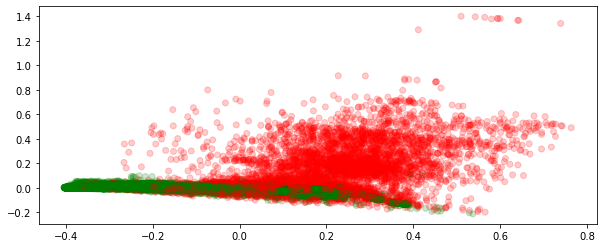

In [15]:
plt.scatter(X[:, 0], X[:, 1], c=color, alpha=.2)
plt.show()

Maybe with 3 main components they look better.

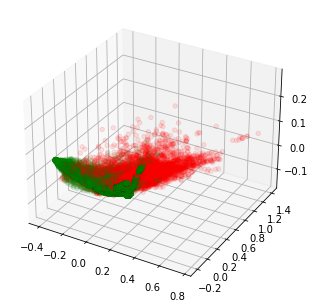

In [16]:
from mpl_toolkits.mplot3d import Axes3D

X = PCA(n_components=3).fit_transform(X_full)

fig = plt.figure()
ax = Axes3D(fig)

ax.scatter(X[:, 0], X[:, 1], X[:, 2], c=color, alpha=.1)
plt.show()

Let's try with less overlap over the windows to reduce the noise.

In [27]:
dataset_path = download_dataset(CACHE_FOLDER)
dataset = load_features.load_features(CACHE_FOLDER, dataset_path, 100, False, 0.3)

39it [01:52,  2.89s/it]


In [28]:
X = dataset[['c1','c2', 'c3', 'c4']]
y = dataset['is_fall']

color = ['red' if i == 1 else 'green' for i in y]

In [29]:
X_full = MaxAbsScaler().fit_transform(X)
X = PCA(n_components=2).fit_transform(X_full)

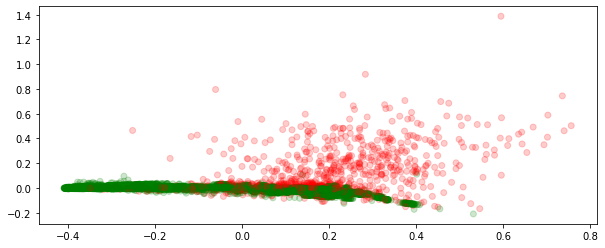

In [30]:
plt.scatter(X[:, 0], X[:, 1], c=color, alpha=.2)
plt.show()

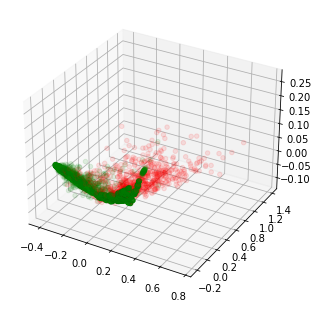

In [31]:
from mpl_toolkits.mplot3d import Axes3D

X = PCA(n_components=3).fit_transform(X_full)

fig = plt.figure()
ax = Axes3D(fig)

ax.scatter(X[:, 0], X[:, 1], X[:, 2], c=color, alpha=.1)
plt.show()

Let's try with filtered data

In [32]:
dataset_path = download_dataset(CACHE_FOLDER)
dataset = load_features.load_features(CACHE_FOLDER, dataset_path, 100, True, 0.9)

39it [05:12,  8.01s/it]


In [34]:
X = dataset[['f_c1','f_c2', 'f_c3', 'f_c4']]
y = dataset['is_fall']

color = ['red' if i == 1 else 'green' for i in y]

In [35]:
X_full = MaxAbsScaler().fit_transform(X)
X = PCA(n_components=2).fit_transform(X_full)

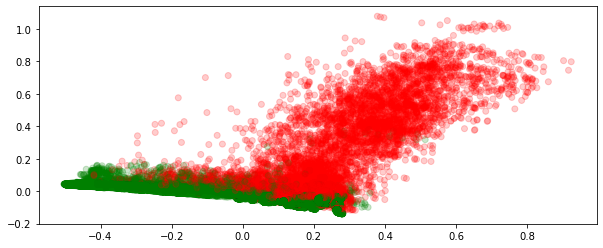

In [36]:
plt.scatter(X[:, 0], X[:, 1], c=color, alpha=.2)
plt.show()

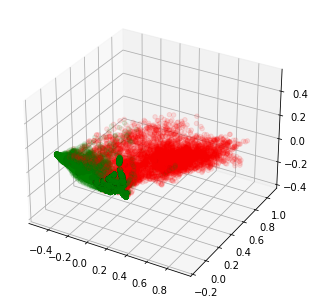

In [37]:
from mpl_toolkits.mplot3d import Axes3D

X = PCA(n_components=3).fit_transform(X_full)

fig = plt.figure()
ax = Axes3D(fig)

ax.scatter(X[:, 0], X[:, 1], X[:, 2], c=color, alpha=.1)
plt.show()

# Less questions, more training

Let's try to train with the same recipe used on IRIS.
Unfortunately it does not complete since our algorithm is too heavy.

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.75, shuffle=True, stratify=y)

In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.model_selection import StratifiedKFold


pipe = Pipeline([
        ('scaler', MaxAbsScaler()),
        ('reduce_dim', PCA()),
        ('classifier', BSVClassifier())
])

In [ ]:
from sklearn.model_selection import GridSearchCV

params = {
    'scaler': [StandardScaler(), MaxAbsScaler(), RobustScaler(), QuantileTransformer()],
    'reduce_dim__n_components': range(X.shape[1])[1:],
    'classifier__n_iter': [10],
    'classifier__penalization': np.random.uniform(1, 100, 3),
    'classifier__q': np.random.uniform(0.1, 100, 10)
}

scoring = ['precision', 'recall', 'f1']
cv = StratifiedKFold(n_splits=3, shuffle=True)
search = GridSearchCV(pipe, params, n_jobs=-1, cv=cv, refit='f1', verbose=5, return_train_score=True, scoring=scoring)

In [ ]:
search.fit(X_train, y_train)

In [ ]:
print(f'Best params: {search.best_params_}')
print(f'Best score: {search.best_score_}')

In [ ]:
search.score(X_test, y_test)

In [ ]:
import pandas as pd

cv_res = pd.DataFrame(search.cv_results_)
cv_res

In [ ]:
clf = search.best_estimator_['classifier']

In [ ]:
from sklearn.metrics import classification_report

print(classification_report(y_test, search.predict(X_test)))